In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
import math
import re
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import os

# 代理配置（根据实际环境修改/删除）
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'

In [14]:
# ===================== 1. 数据清洗函数 =====================
def clean_market_column(text):
    if pd.isna(text) or not isinstance(text, str) or text.strip() == '':
        return np.nan
    nums = re.findall(r'-?\d+\.?\d*', text.replace('\n', ' ').strip())
    if nums:
        try:
            return float(nums[0])
        except:
            return np.nan
    return np.nan

# ===================== 2. 工具函数 =====================
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / (loss + 1e-8)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_max_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative / running_max) - 1
    return drawdown.min()

def backtest_strategy(df_ticker, y_pred_calibrated, initial_capital=10000):
    df_backtest = df_ticker.copy().reset_index()
    valid_len = min(len(df_backtest)-5, len(y_pred_calibrated))
    df_backtest = df_backtest.iloc[:valid_len+5]
    
    df_backtest['signal'] = 0
    df_backtest.loc[:valid_len-1, 'signal'] = np.where(y_pred_calibrated[:valid_len] > 0, 1, -1)
    
    df_backtest['daily_return'] = 0.0
    for i in range(valid_len):
        if i+5 < len(df_backtest):
            total_return = (df_backtest.loc[i+5, 'Close'] / df_backtest.loc[i, 'Close']) - 1
            daily_return = (1 + total_return) ** (1/5) - 1
            df_backtest.loc[i:i+4, 'daily_return'] = daily_return * df_backtest.loc[i, 'signal']
    
    df_backtest['strategy_return'] = df_backtest['daily_return'].fillna(0)
    df_backtest['strategy_cumulative'] = initial_capital * (1 + df_backtest['strategy_return']).cumprod()
    
    df_backtest['buy_hold_return'] = df_backtest['Close'].pct_change().fillna(0)
    df_backtest['buy_hold_cumulative'] = initial_capital * (1 + df_backtest['buy_hold_return']).cumprod()
    
    total_days = len(df_backtest)
    annual_factor = 252 / total_days
    
    strategy_total_return = (df_backtest['strategy_cumulative'].iloc[-1] / initial_capital) - 1
    strategy_annual_return = (1 + strategy_total_return) ** annual_factor - 1
    strategy_max_dd = calculate_max_drawdown(df_backtest['strategy_return'])
    
    buy_hold_total_return = (df_backtest['buy_hold_cumulative'].iloc[-1] / initial_capital) - 1
    buy_hold_annual_return = (1 + buy_hold_total_return) ** annual_factor - 1
    buy_hold_max_dd = calculate_max_drawdown(df_backtest['buy_hold_return'])
    
    return {
        'df_backtest': df_backtest,
        'strategy_total_return': strategy_total_return,
        'strategy_annual_return': strategy_annual_return,
        'strategy_max_dd': strategy_max_dd,
        'buy_hold_total_return': buy_hold_total_return,
        'buy_hold_annual_return': buy_hold_annual_return,
        'buy_hold_max_dd': buy_hold_max_dd
    }

In [15]:
# ===================== 3.1 资金曲线可视化函数（纯英文） =====================
def plot_capital_curve(backtest_result, ticker, save_fig=False):
    df_backtest = backtest_result['df_backtest']
    
    plt.style.use('fivethirtyeight')
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['legend.fontsize'] = 10
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # 绘制策略曲线
    ax.plot(df_backtest['Date'], 
            df_backtest['strategy_cumulative'], 
            label='XGBoost Long-Short Strategy', 
            color='#ff6b6b', 
            linewidth=2.0, 
            alpha=0.8)
    
    # 绘制买入持有曲线
    ax.plot(df_backtest['Date'], 
            df_backtest['buy_hold_cumulative'], 
            label='Buy & Hold Benchmark', 
            color='#4ecdc4', 
            linewidth=2.0, 
            alpha=0.8)
    
    # 计算最终收益
    final_strategy = df_backtest['strategy_cumulative'].iloc[-1]
    final_bh = df_backtest['buy_hold_cumulative'].iloc[-1]
    initial_cap = df_backtest['strategy_cumulative'].iloc[0]
    
    # 添加标注
    ax.annotate(f'Final Value: ${final_strategy:.2f}',
                xy=(df_backtest['Date'].iloc[-1], final_strategy),
                xytext=(10, 5),
                textcoords='offset points',
                color='#ff6b6b',
                fontweight='bold')
    
    ax.annotate(f'Final Value: ${final_bh:.2f}',
                xy=(df_backtest['Date'].iloc[-1], final_bh),
                xytext=(10, -15),
                textcoords='offset points',
                color='#4ecdc4',
                fontweight='bold')
    
    # 图表属性
    ax.set_title(f'{ticker} Strategy vs Buy & Hold Capital Curve (Initial Capital: ${initial_cap:.0f})')
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value (USD)')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    fig.autofmt_xdate()
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(f'{ticker}_capital_curve.png', dpi=300, bbox_inches='tight')
    
    plt.show()

# ===================== 3.2 特征重要性条形图函数 =====================
def plot_feature_importance(model, feature_names, ticker, save_fig=False):
    # 获取特征重要性
    importance = model.get_booster().get_score(importance_type='weight')
    # 转换为DataFrame便于排序和可视化
    feat_imp = pd.DataFrame({
        'feature': list(importance.keys()),
        'importance': list(importance.values())
    })
    # 确保所有特征都在列表中（包括重要性为0的）
    all_features = pd.DataFrame({'feature': feature_names})
    feat_imp = pd.merge(all_features, feat_imp, on='feature', how='left').fillna(0)
    # 按重要性降序排序
    feat_imp = feat_imp.sort_values('importance', ascending=True)
    
    # 设置绘图样式
    plt.style.use('fivethirtyeight')
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 14
    
    # 创建水平条形图
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(feat_imp['feature'], feat_imp['importance'], color='#45b7d1', alpha=0.8)
    
    # 添加数值标签
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}', ha='left', va='center', fontweight='bold')
    
    # 设置图表属性
    ax.set_title(f'{ticker} XGBoost Feature Importance (Weight)')
    ax.set_xlabel('Feature Importance (Number of Splits)')
    ax.set_ylabel('Feature Name')
    ax.grid(True, alpha=0.3, linestyle='--', axis='x')
    
    plt.tight_layout()
    
    # 保存图片（可选）
    if save_fig:
        plt.savefig(f'{ticker}_feature_importance.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # 打印特征重要性数值
    print(f"\n📊 【{ticker}】特征重要性排名：")
    feat_imp_sorted = feat_imp.sort_values('importance', ascending=False)
    for idx, row in feat_imp_sorted.iterrows():
        print(f"   {row['feature']}: {row['importance']:.2f}")
    
    return feat_imp

In [16]:
# ===================== 4. 核心训练函数 =====================
def xgb_train_optimized(df, ticker):
    df = df.copy()
    
    required_cols = ['Close', 'GSPC_pct']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols or len(df) < 100:
        print(f'❌ 【{ticker}】数据不足/缺失关键列（缺失：{missing_cols}），跳过')
        return None
    
    # 特征工程
    df['ma20'] = df['Close'].shift(1).rolling(20, min_periods=20).mean()
    df['ma5'] = df['Close'].shift(1).rolling(5, min_periods=5).mean()
    df['volatility_7d'] = df['Close'].shift(1).rolling(7).std()
    df['rsi_14d'] = calculate_rsi(df['Close'], 14)
    df['price_ma5_ratio'] = df['Close'].shift(1) / df['ma5']
    
    df['stock_pct'] = df['Close'].pct_change(1)
    df['alpha_pct'] = df['stock_pct'] - df['GSPC_pct']
    
    def calculate_residual_pct(stock_pct, gspc_pct, window=20):
        residuals = np.zeros_like(stock_pct)
        residuals[:window-1] = np.nan
        for i in range(window-1, len(stock_pct)):
            X = gspc_pct.iloc[i-window+1:i+1].values.reshape(-1, 1)
            y = stock_pct.iloc[i-window+1:i+1].values
            if np.isnan(X).any() or np.isnan(y).any() or len(X) < window:
                residuals[i] = np.nan
                continue
            lr = LinearRegression()
            lr.fit(X, y)
            y_pred = lr.predict(X)
            residuals[i] = y[-1] - y_pred[-1]
        return pd.Series(residuals, index=stock_pct.index)
    
    df['residual_alpha_pct'] = calculate_residual_pct(df['stock_pct'], df['GSPC_pct'])
    df['stock_vol_7d'] = df['stock_pct'].rolling(7).std()
    df['gspc_vol_7d'] = df['GSPC_pct'].rolling(7).std()
    df['vol_ratio'] = df['stock_vol_7d'] / (df['gspc_vol_7d'] + 0.0001)
    df['beta_20d'] = df['stock_pct'].rolling(20).cov(df['GSPC_pct']) / df['GSPC_pct'].rolling(20).var()
    
    # 目标变量
    df['Close_t5'] = df['Close'].shift(-5)
    df['Target_Return_5d'] = (df['Close_t5'] / df['Close']) - 1
    df = df.dropna(subset=['Target_Return_5d'])
    df = df.dropna()
    if len(df) < 80:
        print(f'❌ 【{ticker}】特征生成后数据不足，跳过')
        return None
    
    FEATURES = [
        'ma5', 'rsi_14d', 'volatility_7d', 'price_ma5_ratio',
        'alpha_pct', 'residual_alpha_pct', 'vol_ratio', 'beta_20d'
    ]
    
    # 滚动回测
    train_window = 90
    test_window = 10   
    step = 10          
    
    all_y_test = []          
    all_y_pred_calibrated = []
    all_test_close = []      
    all_test_stock_pct = []   
    all_test_gspc_pct = []    
    all_test_alpha_pct = []   
    final_model = None  # 保存最终模型用于特征重要性分析
    
    max_start = len(df) - train_window - test_window
    if max_start <= 0:
        print(f'❌ 【{ticker}】数据量不足以支撑滚动回测，跳过')
        return None
    
    for start in range(0, max_start, step):
        train_end = start + train_window
        test_end = train_end + test_window
        
        train = df.iloc[start:train_end]
        test = df.iloc[train_end:test_end]
        
        if len(test) < test_window:
            break
        
        X_train, y_train = train[FEATURES], train['Target_Return_5d']
        X_test, y_test = test[FEATURES], test['Target_Return_5d']
        
        model = xgb.XGBRegressor(
            n_estimators=120,         
            learning_rate=0.04,       
            max_depth=4,              
            subsample=0.85,            
            colsample_bytree=0.85,     
            reg_alpha=0.02,          
            reg_lambda=0.08,           
            random_state=42,
            objective='reg:squarederror',
            eval_metric='rmse'
        )
        model.fit(X_train, y_train)
        final_model = model  # 更新为最新的模型
        
        y_pred = model.predict(X_test)
        pred_mean = y_pred.mean()
        true_mean = y_test.mean()
        y_pred_calibrated = y_pred - pred_mean + true_mean
        
        all_y_test.extend(y_test.values)
        all_y_pred_calibrated.extend(y_pred_calibrated)
        all_test_close.extend(test['Close'].values)
        all_test_stock_pct.extend(test['stock_pct'].values)
        all_test_gspc_pct.extend(test['GSPC_pct'].values)
        all_test_alpha_pct.extend(test['alpha_pct'].values)
    
    # 结果处理
    all_y_test = np.array(all_y_test)
    all_y_pred_calibrated = np.array(all_y_pred_calibrated)
    all_test_close = np.array(all_test_close)
    all_test_stock_pct = np.array(all_test_stock_pct)
    all_test_gspc_pct = np.array(all_test_gspc_pct)
    
    valid_mask = ~(np.isnan(all_y_test) | np.isnan(all_y_pred_calibrated) | np.isnan(all_test_close))
    all_y_test = all_y_test[valid_mask]
    all_y_pred_calibrated = all_y_pred_calibrated[valid_mask]
    all_test_close = all_test_close[valid_mask]
    all_test_stock_pct = all_test_stock_pct[valid_mask]
    all_test_gspc_pct = all_test_gspc_pct[valid_mask]
    
    if len(all_y_test) < 10:
        print(f'❌ 【{ticker}】有效回测数据不足，跳过')
        return None
    
    # 指标计算
    pct_mse_optimized = mean_squared_error(all_y_test, all_y_pred_calibrated)
    pct_r2 = r2_score(all_y_test, all_y_pred_calibrated)
    
    actual_direction = np.where(all_y_test > 0, 1, 0)
    pred_direction = np.where(all_y_pred_calibrated > 0, 1, 0)
    correct_predictions = np.sum(actual_direction == pred_direction)
    total_predictions = len(actual_direction)
    direction_accuracy = correct_predictions / total_predictions * 100
    
    common_len = min(len(all_test_close)-5, len(all_y_pred_calibrated))
    if common_len < 5:
        print(f'❌ 【{ticker}】股价评估数据不足，跳过')
        return None
    
    y_true_price = all_test_close[5:common_len+5]
    y_naive_price = all_test_close[:common_len]
    y_xgb_price = all_test_close[:common_len] * (1 + all_y_pred_calibrated[:common_len])
    y_mean_return = np.mean(all_y_test[:common_len])
    y_mean_price = all_test_close[:common_len] * (1 + y_mean_return)
    
    RMSE_naive = math.sqrt(mean_squared_error(y_true_price, y_naive_price))
    RMSE_mean = math.sqrt(mean_squared_error(y_true_price, y_mean_price))
    RMSE_xgb = math.sqrt(mean_squared_error(y_true_price, y_xgb_price))
    
    # 回测调用
    backtest_result = backtest_strategy(df, all_y_pred_calibrated)
    
    # 输出结果
    print(f'\n✅ 【{ticker}】优化版回测结果（未来5天总收益率预测）')
    print(f'   5天总收益MSE: {pct_mse_optimized:.6f} | R²: {pct_r2:.4f}')
    print(f'   🎯 涨跌方向准确率: {direction_accuracy:.2f}% ({correct_predictions}/{total_predictions})')
    print(f"\n📈 【{ticker}】虚拟交易回测结果")
    print(f'   📊 策略总收益: {backtest_result["strategy_total_return"]:.2%} | 年化收益: {backtest_result["strategy_annual_return"]:.2%}')
    print(f'   📊 买入持有总收益: {backtest_result["buy_hold_total_return"]:.2%} | 年化收益: {backtest_result["buy_hold_annual_return"]:.2%}')
    print(f'   🚨 策略最大回撤: {backtest_result["strategy_max_dd"]:.2%} | 基准最大回撤: {backtest_result["buy_hold_max_dd"]:.2%}')
    print(f"\n📌 【{ticker}】基准对比（预测5天后价格）")
    print(f"   傻瓜模型RMSE: {RMSE_naive:.2f} USD")
    print(f"   均值模型RMSE: {RMSE_mean:.2f} USD")
    print(f"   XGBoost模型RMSE: {RMSE_xgb:.2f} USD")
    
    is_beat_naive = RMSE_xgb < RMSE_naive
    is_beat_mean = RMSE_xgb < RMSE_mean
    beat_naive_ratio = (RMSE_naive - RMSE_xgb) / RMSE_naive * 100 if RMSE_naive !=0 else 0
    beat_mean_ratio = (RMSE_mean - RMSE_xgb) / RMSE_mean * 100 if RMSE_mean !=0 else 0
    
    if is_beat_naive and is_beat_mean:
        print(f"   ✅ 同时打败两个基准！对比傻瓜模型误差降低 {beat_naive_ratio:.1f}%，对比均值模型误差降低 {beat_mean_ratio:.1f}%")
    elif is_beat_naive and not is_beat_mean:
        print(f"   ⚠️ 仅打败傻瓜模型（误差降低 {beat_naive_ratio:.1f}%），未打败均值模型")
    elif not is_beat_naive and is_beat_mean:
        print(f"   ⚠️ 仅打败均值模型（误差降低 {beat_mean_ratio:.1f}%），未打败傻瓜模型")
    else:
        print(f"   ❌ 未打败任何基准")
    
    return {
        'y_test_pct': all_y_test,
        'y_pred_pct_calibrated': all_y_pred_calibrated,
        'y_test_price': y_true_price,
        'y_pred_price': y_xgb_price,
        'test_close': all_test_close,
        'pct_mse_optimized': pct_mse_optimized,
        'pct_r2': pct_r2,
        'direction_accuracy': direction_accuracy,
        'correct_predictions': correct_predictions,
        'total_predictions': total_predictions,
        'RMSE_naive': RMSE_naive,
        'RMSE_mean': RMSE_mean,
        'RMSE_xgb': RMSE_xgb,
        'backtest_result': backtest_result,
        'final_model': final_model,  # 新增：返回最终模型
        'feature_names': FEATURES    # 新增：返回特征名称列表
    }


✅ 【AAPL】优化版回测结果（未来5天总收益率预测）
   5天总收益MSE: 0.001063 | R²: 0.4280
   🎯 涨跌方向准确率: 71.84% (273/380)

📈 【AAPL】虚拟交易回测结果
   📊 策略总收益: 6.41% | 年化收益: 4.15%
   📊 买入持有总收益: 14.15% | 年化收益: 9.05%
   🚨 策略最大回撤: -22.06% | 基准最大回撤: -33.36%

📌 【AAPL】基准对比（预测5天后价格）
   傻瓜模型RMSE: 9.53 USD
   均值模型RMSE: 9.48 USD
   XGBoost模型RMSE: 7.18 USD
   ✅ 同时打败两个基准！对比傻瓜模型误差降低 24.6%，对比均值模型误差降低 24.3%

✅ 【GOOG】优化版回测结果（未来5天总收益率预测）
   5天总收益MSE: 0.001173 | R²: 0.3436
   🎯 涨跌方向准确率: 73.95% (281/380)

📈 【GOOG】虚拟交易回测结果
   📊 策略总收益: -3.65% | 年化收益: -2.41%
   📊 买入持有总收益: 29.17% | 年化收益: 18.24%
   🚨 策略最大回撤: -22.49% | 基准最大回撤: -29.35%

📌 【GOOG】基准对比（预测5天后价格）
   傻瓜模型RMSE: 8.65 USD
   均值模型RMSE: 8.37 USD
   XGBoost模型RMSE: 6.72 USD
   ✅ 同时打败两个基准！对比傻瓜模型误差降低 22.4%，对比均值模型误差降低 19.8%

✅ 【META】优化版回测结果（未来5天总收益率预测）
   5天总收益MSE: 0.001447 | R²: 0.3646
   🎯 涨跌方向准确率: 71.84% (273/380)

📈 【META】虚拟交易回测结果
   📊 策略总收益: 43.67% | 年化收益: 26.77%
   📊 买入持有总收益: 94.82% | 年化收益: 54.73%
   🚨 策略最大回撤: -17.77% | 基准最大回撤: -34.15%

📌 【META】基准对比（预测5天后价格）
   傻瓜模型RMSE: 29.72 USD
   均值模型

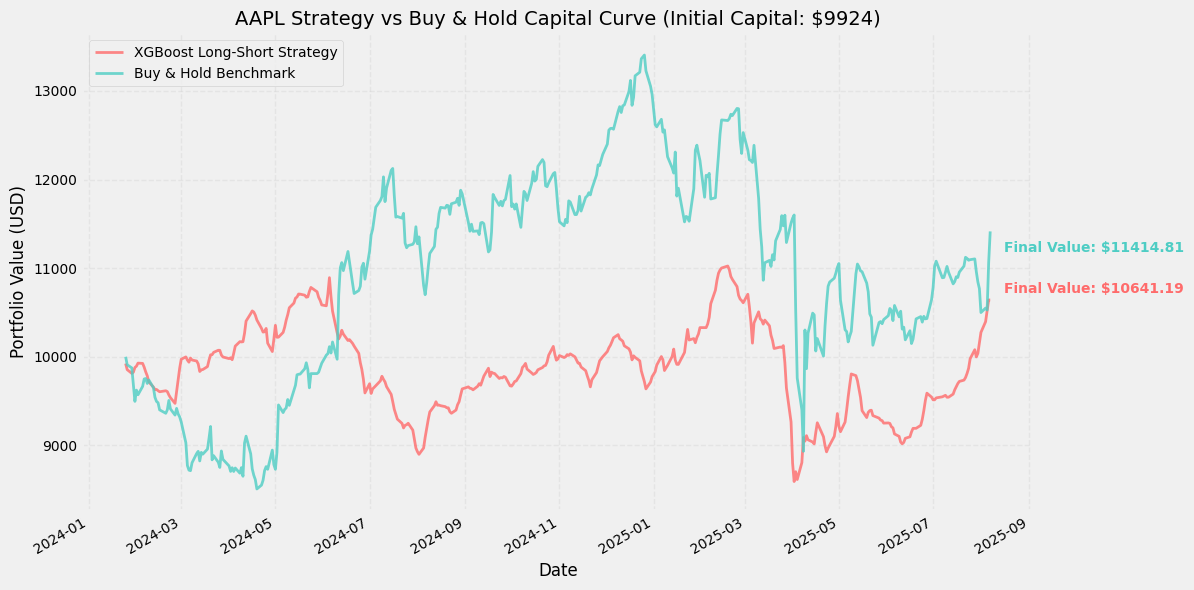

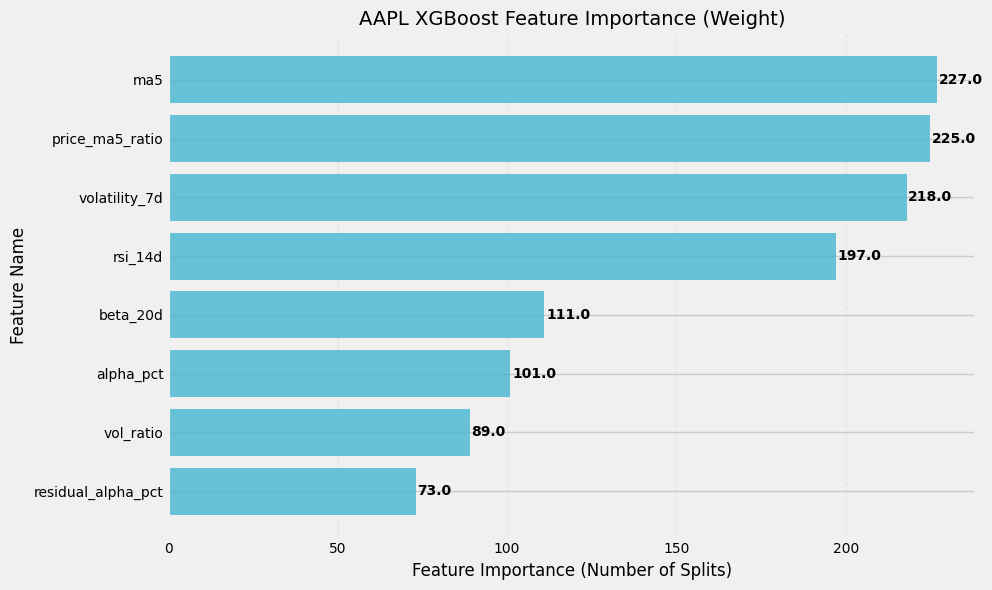


📊 【AAPL】特征重要性排名：
   ma5: 227.00
   price_ma5_ratio: 225.00
   volatility_7d: 218.00
   rsi_14d: 197.00
   beta_20d: 111.00
   alpha_pct: 101.00
   vol_ratio: 89.00
   residual_alpha_pct: 73.00


In [17]:
# ===================== 5. 数据加载与回测执行 =====================
# 加载数据
df = pd.read_csv(
    'final_merged_data.csv',
    encoding='utf-8',
    sep=',',
    quotechar='"',
    na_values=['', 'NaN', 'N/A'],
    keep_default_na=True
)

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
df.set_index('Date', inplace=True)
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

# 清洗市场数据列
market_cols = ['GSPC_Close', 'GSPC_pct', 'GSPC_ma5', 'VIX_Close', 'VIX_pct', 'VIX_ma5']
for col in market_cols:
    if col in df.columns:
        df[col] = df[col].apply(clean_market_column)

# 数值化核心列
core_cols = ['Open', 'High', 'Low', 'Close', 'Volume'] + market_cols
core_cols = [col for col in core_cols if col in df.columns]
for col in core_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df[core_cols] = df[core_cols].ffill().bfill().fillna(0)

# 运行回测
stock_results_optimized = {}
for ticker, single_stock_df in df.groupby('Ticker'):
    stock_results_optimized[ticker] = xgb_train_optimized(single_stock_df, ticker)

# 可视化AAPL结果（资金曲线 + 特征重要性）
if 'AAPL' in stock_results_optimized and stock_results_optimized['AAPL'] is not None:
    res = stock_results_optimized['AAPL']
    backtest_res = res['backtest_result']
    
    # 1. 绘制资金曲线
    plot_capital_curve(backtest_res, ticker='AAPL', save_fig=False)
    
    # 2. 绘制特征重要性条形图
    if res['final_model'] is not None:
        plot_feature_importance(res['final_model'], res['feature_names'], ticker='AAPL', save_fig=False)

# 批量绘制所有股票（可选）
# for ticker, res in stock_results_optimized.items():
#     if res is not None:
#         backtest_res = res['backtest_result']
#         plot_capital_curve(backtest_res, ticker=ticker, save_fig=False)
#         if res['final_model'] is not None:
#             plot_feature_importance(res['final_model'], res['feature_names'], ticker=ticker, save_fig=False)

In [18]:
# ===================== 6. 汇总结果 =====================
print("\n" + "="*80)
print("📊 优化版回测结果汇总（未来5天总收益率预测）：")
print("="*80)

total_tickers = len([k for k, v in stock_results_optimized.items() if v is not None])
beat_naive_count = 0
beat_mean_count = 0
avg_accuracy = 0.0
avg_strategy_return = 0.0
avg_buy_hold_return = 0.0

for ticker, res in stock_results_optimized.items():
    if res is None:
        continue
    
    beat_naive = res['RMSE_xgb'] < res['RMSE_naive']
    beat_mean = res['RMSE_xgb'] < res['RMSE_mean']
    
    if beat_naive: beat_naive_count += 1
    if beat_mean: beat_mean_count += 1
    avg_accuracy += res['direction_accuracy']
    avg_strategy_return += res['backtest_result']['strategy_total_return']
    avg_buy_hold_return += res['backtest_result']['buy_hold_total_return']
    
    print(f"\n📈 【{ticker}】")
    print(f"  ├─ 5天总收益R²：{res['pct_r2']:.4f} | MSE：{res['pct_mse_optimized']:.6f}")
    print(f"  ├─ 🎯 涨跌准确率：{res['direction_accuracy']:.2f}% ({res['correct_predictions']}/{res['total_predictions']})")
    print(f"  ├─ 📊 策略收益：{res['backtest_result']['strategy_total_return']:.2%} | 基准收益：{res['backtest_result']['buy_hold_total_return']:.2%}")
    print(f"  ├─ 🚨 策略最大回撤：{res['backtest_result']['strategy_max_dd']:.2%} | 基准最大回撤：{res['backtest_result']['buy_hold_max_dd']:.2%}")
    print(f"  ├─ RMSE对比（USD）：傻瓜模型 {res['RMSE_naive']:.2f} | 均值模型 {res['RMSE_mean']:.2f} | XGBoost {res['RMSE_xgb']:.2f}")
    print(f"  └─ 打败基准：傻瓜模型 {'✅' if beat_naive else '❌'} | 均值模型 {'✅' if beat_mean else '❌'}")
    print(f"     {'-'*50}")

if total_tickers > 0:
    avg_accuracy = avg_accuracy / total_tickers
    avg_strategy_return = avg_strategy_return / total_tickers
    avg_buy_hold_return = avg_buy_hold_return / total_tickers
    print(f"\n📋 整体统计：")
    print(f"  - 有效回测股票数：{total_tickers}")
    print(f"  - 平均涨跌准确率：{avg_accuracy:.2f}%")
    print(f"  - 平均策略总收益：{avg_strategy_return:.2%} | 平均基准总收益：{avg_buy_hold_return:.2%}")
    print(f"  - 打败傻瓜模型：{beat_naive_count}/{total_tickers} ({beat_naive_count/total_tickers*100:.1f}%)")
    print(f"  - 打败均值模型：{beat_mean_count}/{total_tickers} ({beat_mean_count/total_tickers*100:.1f}%)")
else:
    print("\n📋 整体统计：无有效回测结果")


📊 优化版回测结果汇总（未来5天总收益率预测）：

📈 【AAPL】
  ├─ 5天总收益R²：0.4280 | MSE：0.001063
  ├─ 🎯 涨跌准确率：71.84% (273/380)
  ├─ 📊 策略收益：6.41% | 基准收益：14.15%
  ├─ 🚨 策略最大回撤：-22.06% | 基准最大回撤：-33.36%
  ├─ RMSE对比（USD）：傻瓜模型 9.53 | 均值模型 9.48 | XGBoost 7.18
  └─ 打败基准：傻瓜模型 ✅ | 均值模型 ✅
     --------------------------------------------------

📈 【GOOG】
  ├─ 5天总收益R²：0.3436 | MSE：0.001173
  ├─ 🎯 涨跌准确率：73.95% (281/380)
  ├─ 📊 策略收益：-3.65% | 基准收益：29.17%
  ├─ 🚨 策略最大回撤：-22.49% | 基准最大回撤：-29.35%
  ├─ RMSE对比（USD）：傻瓜模型 8.65 | 均值模型 8.37 | XGBoost 6.72
  └─ 打败基准：傻瓜模型 ✅ | 均值模型 ✅
     --------------------------------------------------

📈 【META】
  ├─ 5天总收益R²：0.3646 | MSE：0.001447
  ├─ 🎯 涨跌准确率：71.84% (273/380)
  ├─ 📊 策略收益：43.67% | 基准收益：94.82%
  ├─ 🚨 策略最大回撤：-17.77% | 基准最大回撤：-34.15%
  ├─ RMSE对比（USD）：傻瓜模型 29.72 | 均值模型 29.75 | XGBoost 23.06
  └─ 打败基准：傻瓜模型 ✅ | 均值模型 ✅
     --------------------------------------------------

📈 【MSFT】
  ├─ 5天总收益R²：0.4230 | MSE：0.000588
  ├─ 🎯 涨跌准确率：76.58% (291/380)
  ├─ 📊 策略收益：1.06% | 基准收益：30.10%
  ├─ 🚨 策略最大回撤：-1